### **Plots for qualitative analysis - Joan**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import pandas as pd
import textwrap

In [21]:
def plot_heatmap(d, idx=0, model='base'):
    sample_jsds = d[idx]['jsds']
    tokens = d[idx]['words']
    layers = np.arange(1, get_num_layers(model) + 1)
    question = d[idx]['question']
    context = d[idx]['context']

    # Create a DataFrame from the sample JSDS data
    data = []
    for i in layers:
        layer_data = []
        for token in np.arange(0, len(tokens)):
            value = sample_jsds[token].get(i, -1) * 100000
            # Apply log transformation to avoid issues with zero values
            if value == -1 * 100000:
                layer_data.append(np.nan)  # Use NaN to handle "exited early" cases
            else:
                layer_data.append(np.log1p(value))  # log1p handles log(1 + x) to avoid log(0) issue
        data.append(layer_data)

    df = pd.DataFrame(data, index=[f"Layer {i}" for i in layers], columns=tokens)

    # Plot the heatmap
    num_tokens = len(tokens)
    fig_width = max(10, num_tokens)  # Adjust the denominator for desired width scaling

    plt.figure(figsize=(fig_width, 10))
    heatmap = sns.heatmap(df, annot=False, fmt=".4f", cmap="Purples", cbar=True, linewidths=0.5, linecolor='gray')

    # Add custom annotations
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            value = df.iat[i, j]
            if np.isnan(value):
                heatmap.text(j + 0.5, i + 0.5, '•', color='red', ha='center', va='center', fontsize=12, fontweight='bold')
            else:
                heatmap.text(j + 0.5, i + 0.5, f'{value:.4f}', color='white', ha='center', va='center', fontsize=8)

    # Customize the color bar to indicate log scale
    cbar = heatmap.collections[0].colorbar
    cbar.set_label('Log(1 + JSD Value)')  # Customize the color bar label

    # Customize the plot
    if question is not None:
        plt.title(f'Heatmap of JSDS Values for Each Token\nQuestion: {question}', fontsize=16)
        plt.xlabel('Tokens', fontsize=12)
        plt.ylabel('Layers', fontsize=12)
        plt.xticks(rotation=45, ha='right')
    else:
        # break the context into multiple lines
        wrapped_context = "\n".join(textwrap.wrap(context, width=80))
        plt.title(f'Heatmap of JSDS Values for Each Token\nContext: {wrapped_context}', fontsize=16)
        plt.xlabel('Tokens', fontsize=12)
        plt.ylabel('Layers', fontsize=12)
        plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.savefig(f'heatmap_SamSum_noFT_{idx}_deeper.png', dpi=300)
    plt.show()


# Example of a get_num_layers function, you should replace it with the actual implementation
def get_num_layers(model):
    if model == 'base':
        return 12
    elif model == 'large':
        return 24
    else:
        raise ValueError("Unsupported model type")

In [22]:
def plot_average_exiting_layers(qa_pairs, average_exits, all_tokens, title='Average Exiting Layer per Token Position'):
    # Ensure the tokens list covers all positions in the average_exits dictionary
    positions = sorted(average_exits.keys())
    avg_layers = [average_exits[pos] for pos in positions]
    std_layers = [np.std(average_exits[pos]) for pos in positions]
    
    # Calculate frequency of each position
    position_counts = {pos: 0 for pos in positions}
    for qa in qa_pairs:
        jsds_list = qa['jsds']
        for token, layers in jsds_list.items():
            if token in position_counts:
                position_counts[token] += 1

    # Normalize frequencies for color mapping
    max_count = max(position_counts.values())
    normalized_counts = [position_counts[pos] / max_count for pos in positions]
    
    # Create color map
    norm = Normalize(vmin=0, vmax=1)
    cmap = plt.get_cmap('viridis')
    colors = [cmap(norm(count)) for count in normalized_counts]
    
    plt.figure(figsize=(len(positions) // 5, 10))
    sns.set(style="whitegrid")

    # Bar plot with error bars and color mapping
    bars = plt.bar(positions, avg_layers, yerr=std_layers, capsize=5, color=colors)
    min_exit_layer = 2
    plt.axhline(y=min_exit_layer, color='r', linestyle='--', linewidth=2, label=f'Minimum Exit Layer: {min_exit_layer}')

    # Add annotations
    for bar, layer in zip(bars, avg_layers):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{layer:.2f}', ha='center', va='bottom', fontsize=10)

    # Customize plot
    plt.xlabel('Token Position', fontsize=14)
    plt.ylabel('Average Exiting Layer', fontsize=14)
    plt.title(title + " - SQuAD", fontsize=18)
    plt.xticks(ticks=positions, labels=[all_tokens[pos] for pos in positions], rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    # Color bar for frequency
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=[0, 0.5, 1])
    cbar.set_label('Normalized Frequency', fontsize=14)
    cbar.set_ticklabels(['Low', 'Medium', 'High'])
    
    plt.savefig('average_exiting_layers.png', dpi=300, bbox_inches='tight')
    plt.savefig('average_exiting_layers.svg', format='svg', dpi=300, bbox_inches='tight')
    plt.show()

In [23]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def parse_log(log_text, task='qa'):
    # Initialize the list to store all Q/A pairs
    qa_pairs = []

    # Split the log text into sections based on the '-END CONTEXT-' delimiter
    sections = log_text.strip().split('-END CONTEXT-')

    # Define regex patterns
    jsds_pattern = re.compile(r"JSDS:\s+{([^}]+)}")
    word_pattern = re.compile(r"Word:\s+(\S+)")
    
    if task == 'qa':
        question_pattern = re.compile(r"question:\s+(.*?)\s*context:")
        context_pattern = re.compile(r"context:\s+(.*)")
    elif task == 'translation':
        pass
    elif task == 'summarization':
        summarization_pattern = re.compile(r"summarize:\s+(.*)")
    else:
        raise ValueError(f"Invalid task: {task}")

    # Process each section separately
    for section in sections:
        section = section.strip()  # Clean up leading/trailing whitespace

        if not section:
            continue
        
        if task == 'qa': 
            # Extract question
            question_match = question_pattern.search(section)
            question = question_match.group(1).strip() if question_match else None

            # Extract context
            context_match = context_pattern.search(section)
            context = context_match.group(1).strip() if context_match else None
        elif task == 'summarization':
            summarization_match = summarization_pattern.search(section)
            question = None
            context = summarization_match.group(1).strip() if summarization_match else None
        elif task == 'translation':
            pass
        else:
            raise ValueError(f"Invalid task: {task}")

        # Extract all JSDS
        jsds_matches = jsds_pattern.findall(section)
        jsds_list = {}
        for i, jsds in enumerate(jsds_matches):
            layer_jsds = re.findall(r"(\d+):\s*tensor\(([\d\.e-]+),", jsds)
            jsds_dict = {int(layer): float(value) for layer, value in layer_jsds}
            jsds_list[i] = jsds_dict

        # Extract all words
        word_matches = word_pattern.findall(section)
        words = [match if match != "Token_id:" else ' ' for match in word_matches]  # Handle whitespace tokens

        # Add the Q/A pair to the list
        qa_pairs.append({
            'question': question,
            'context': context,
            'jsds': jsds_list,
            'words': words
        })

    return qa_pairs

def average_exiting_layer_per_position(qa_pairs):
    max_layers_per_position = {}

    for qa in qa_pairs:
        jsds_list = qa['jsds']
        for token, layers in jsds_list.items():
            max_layer = max(layers.keys()) if layers else 0
            if token not in max_layers_per_position:
                max_layers_per_position[token] = []
            max_layers_per_position[token].append(max_layer)
    
    average_exits = {token: np.mean(layers) for token, layers in max_layers_per_position.items()}
    return average_exits

def plot_average_exiting_layers(average_exits, tokens):
    positions = list(average_exits.keys())
    avg_layers = [average_exits[pos] for pos in positions]
    std_layers = [np.std(average_exits[pos]) for pos in positions]

    plt.figure(figsize=(14, 8))
    sns.set(style="whitegrid")

    # Bar plot with error bars
    bars = plt.bar(positions, avg_layers, yerr=std_layers, capsize=5, color=sns.color_palette("viridis", len(positions)))

    # Add annotations
    for bar, layer in zip(bars, avg_layers):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{layer:.2f}', ha='center', va='bottom', fontsize=10)

    # Customize plot
    plt.xlabel('Token Position', fontsize=14)
    plt.ylabel('Average Exiting Layer', fontsize=14)
    plt.title('Average Exiting Layer per Token Position', fontsize=18)
    plt.xticks(ticks=positions, labels=[tokens[pos] for pos in positions], rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


In [24]:
import re
import numpy as np

def parse_log(log_text, task='qa'):
    # Initialize the list to store all Q/A pairs
    qa_pairs = []

    # Split the log text into sections based on the '-END CONTEXT-' delimiter
    sections = log_text.strip().split('-END CONTEXT-')

    # Define regex patterns
    jsds_pattern = re.compile(r"JSDS:\s+{([^}]+)}")
    word_pattern = re.compile(r"Word:\s+(\S+)")
    
    if task == 'qa':
        question_pattern = re.compile(r"question:\s+(.*?)\s*context:")
        context_pattern = re.compile(r"context:\s+(.*)")
    elif task == 'translation':
        pass
    elif task == 'summarization':
        summarization_pattern = re.compile(r"summarize:\s+(.*)")
    else:
        raise ValueError(f"Invalid task: {task}")

    # Process each section separately
    for section in sections:
        section = section.strip()  # Clean up leading/trailing whitespace

        if not section:
            continue
        
        if task == 'qa': 
            # Extract question
            question_match = question_pattern.search(section)
            question = question_match.group(1).strip() if question_match else None

            # Extract context
            context_match = context_pattern.search(section)
            context = context_match.group(1).strip() if context_match else None
        elif task == 'summarization':
            summarization_match = summarization_pattern.search(section)
            question = None
            context = summarization_match.group(1).strip() if summarization_match else None
        elif task == 'translation':
            pass
        else:
            raise ValueError(f"Invalid task: {task}")

        # Extract all JSDS
        jsds_matches = jsds_pattern.findall(section)
        jsds_list = {}
        for i, jsds in enumerate(jsds_matches):
            layer_jsds = re.findall(r"(\d+):\s*tensor\(([\d\.e-]+),", jsds)
            jsds_dict = {int(layer): float(value) for layer, value in layer_jsds}
            jsds_list[i] = jsds_dict

        # Extract all words
        word_matches = word_pattern.findall(section)
        words = [match if match != "Token_id:" else ' ' for match in word_matches]  # Handle whitespace tokens

        # Add the Q/A pair to the list
        qa_pairs.append({
            'question': question,
            'context': context,
            'jsds': jsds_list,
            'words': words
        })

    return qa_pairs

def average_exiting_layer_per_position(qa_pairs):
    max_layers_per_position = {}

    for qa in qa_pairs:
        jsds_list = qa['jsds']
        for token, layers in jsds_list.items():
            max_layer = max(layers.keys()) if layers else 0
            if token not in max_layers_per_position:
                max_layers_per_position[token] = []
            max_layers_per_position[token].append(max_layer)
    
    average_exits = {token: np.mean(layers) for token, layers in max_layers_per_position.items()}
    return average_exits

In [25]:
log_text = 'logs/DoLA_JSDs_samsum_noft.txt'
with open(log_text, 'r') as file:
    log_text = file.read()

log_text = log_text.split('*** Evaluate ***')[1]

In [26]:
qa_pairs = parse_log(log_text, task='summarization')

### Squad: use plot_heatmap(qa_pairs, idx=14, model='large')


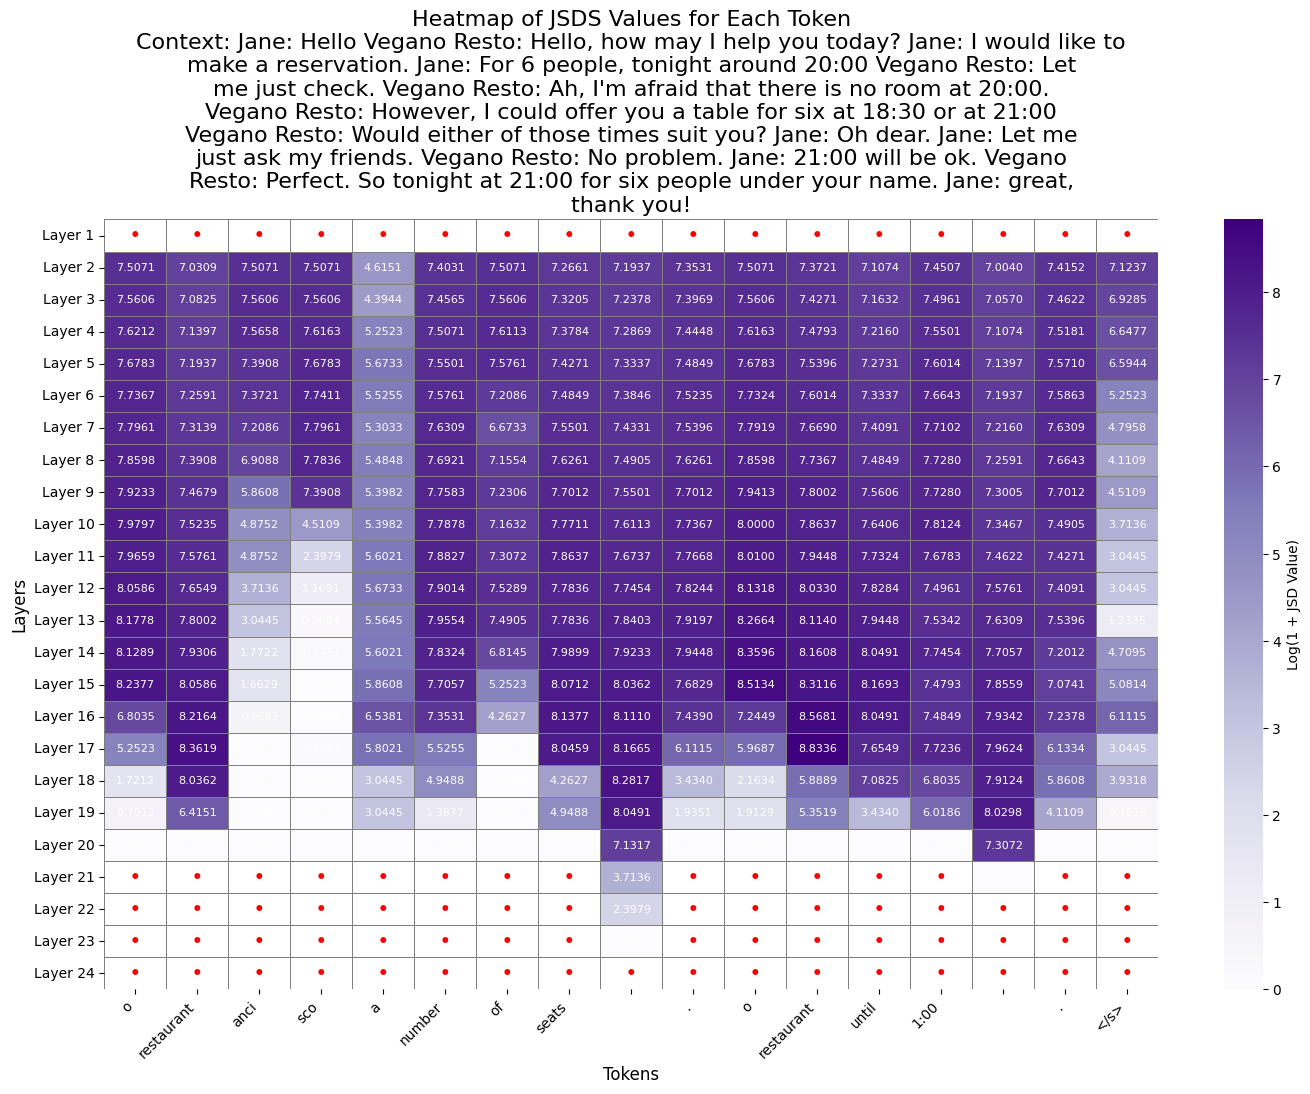

In [27]:
plot_heatmap(qa_pairs, idx=8, model='large')

## **Scenario Introduction**

Simulating probits to assess a bug in the implementation

In [105]:
import torch

# random torch tensor
probits_exp = torch.rand(20)
mask = probits_exp > 0.3
probits_am = torch.rand(20)

In [106]:
probits_exp

tensor([0.2293, 0.3847, 0.2573, 0.0179, 0.4472, 0.7584, 0.8504, 0.5637, 0.0452,
        0.7914, 0.3347, 0.8052, 0.4765, 0.0830, 0.0971, 0.8164, 0.2946, 0.0883,
        0.8523, 0.1517])

### **Classic, no scaling**

In [107]:
s = torch.zeros_like(probits_exp)
#s = probits_exp.detach().clone()
contrast = (torch.log(probits_exp[mask]) - torch.log(probits_am[mask])) #/ 2.5 # temperature scaling
s[mask] = contrast
# DoLA Implementation:
s.masked_fill_(~mask, -1e9)
s = torch.softmax(s, dim=-1)#.mul_(torch.sum(probits_exp))
s[~mask] = probits_exp[~mask]

In [108]:
print(s), mask, torch.argmax(s), torch.argmax(probits_exp), mask[torch.argmax(s)], mask[torch.argmax(probits_exp)]

tensor([0.2293, 0.0259, 0.2573, 0.0179, 0.0509, 0.0461, 0.0424, 0.0487, 0.0452,
        0.2603, 0.0576, 0.1388, 0.1389, 0.0830, 0.0971, 0.0563, 0.2946, 0.0883,
        0.1341, 0.1517])


(None,
 tensor([False,  True, False, False,  True,  True,  True,  True, False,  True,
          True,  True,  True, False, False,  True, False, False,  True, False]),
 tensor(16),
 tensor(18),
 tensor(False),
 tensor(True))

In [109]:
# are there probits larger than 1?
print(torch.any(s > 1))

tensor(False)


In [110]:
# predicted confidence:
torch.topk(s,2)[0],\
torch.topk(s, 2)[0][0] - torch.topk(s, 2)[0][1]  

(tensor([0.2946, 0.2603]), tensor(0.0343))

### **Scaling WITHIN Softmax**

In [111]:
s = torch.zeros_like(probits_exp)
#s = probits_exp.detach().clone()
contrast = (torch.log(probits_exp[mask]) - torch.log(probits_am[mask])) #/ 2.5 # temperature scaling
s[mask] = contrast
# DoLA Implementation:
s.masked_fill_(~mask, -1e9)
s = torch.softmax(s.mul_(torch.sum(probits_exp)), dim=-1)
s[~mask] = probits_exp[~mask]

In [112]:
print(s), mask, torch.argmax(s), torch.argmax(probits_exp), mask[torch.argmax(s)], mask[torch.argmax(probits_exp)]

tensor([2.2935e-01, 4.2310e-09, 2.5729e-01, 1.7906e-02, 1.1908e-06, 5.2840e-07,
        2.6086e-07, 8.2413e-07, 4.5211e-02, 9.8569e-01, 3.3482e-06, 5.1833e-03,
        5.2226e-03, 8.2969e-02, 9.7061e-02, 2.7974e-06, 2.9463e-01, 8.8281e-02,
        3.8935e-03, 1.5174e-01])


(None,
 tensor([False,  True, False, False,  True,  True,  True,  True, False,  True,
          True,  True,  True, False, False,  True, False, False,  True, False]),
 tensor(9),
 tensor(18),
 tensor(True),
 tensor(True))

In [115]:
# are there probits larger than 1?
print(torch.any(s > 1))

tensor(False)


In [116]:
# predicted confidence:
torch.topk(s,2)[0],\
torch.topk(s, 2)[0][0] - torch.topk(s, 2)[0][1]  

(tensor([0.9857, 0.2946]), tensor(0.6911))

### **Scaling OUTSIDE of Softmax**

In [117]:
s = torch.zeros_like(probits_exp)
#s = probits_exp.detach().clone()
contrast = (torch.log(probits_exp[mask]) - torch.log(probits_am[mask])) #/ 2.5 # temperature scaling
s[mask] = contrast
# DoLA Implementation:
s.masked_fill_(~mask, -1e9)
s = torch.softmax(s, dim=-1).mul_(torch.sum(probits_exp))
s[~mask] = probits_exp[~mask]

In [118]:
print(s), mask, torch.argmax(s), torch.argmax(probits_exp), mask[torch.argmax(s)], mask[torch.argmax(probits_exp)]

tensor([0.2293, 0.2159, 0.2573, 0.0179, 0.4244, 0.3851, 0.3538, 0.4061, 0.0452,
        2.1724, 0.4804, 1.1583, 1.1594, 0.0830, 0.0971, 0.4702, 0.2946, 0.0883,
        1.1193, 0.1517])


(None,
 tensor([False,  True, False, False,  True,  True,  True,  True, False,  True,
          True,  True,  True, False, False,  True, False, False,  True, False]),
 tensor(9),
 tensor(18),
 tensor(True),
 tensor(True))

In [119]:
# are there probits larger than 1?
print(torch.any(s > 1))
# where (index)?
print(torch.where(s > 1))

tensor(True)
(tensor([ 9, 11, 12, 18]),)


In [120]:
# predicted confidence:
torch.topk(s,2)[0],\
torch.topk(s, 2)[0][0] - torch.topk(s, 2)[0][1]  

(tensor([2.1724, 1.1594]), tensor(1.0130))

### **No OOD masking**

In [121]:
s = torch.zeros_like(probits_exp)
#s = probits_exp.detach().clone()
contrast = (torch.log(probits_exp[mask]) - torch.log(probits_am[mask])) #/ 2.5 # temperature scaling
s[mask] = contrast
# DoLA Implementation:
#s.masked_fill_(~mask, -1e9)
s[mask] = torch.softmax(s[mask].mul_(torch.sum(probits_exp)), dim=-1)
s[~mask] = probits_exp[~mask]

In [122]:
print(s), mask, torch.argmax(s), torch.argmax(probits_exp), mask[torch.argmax(s)], mask[torch.argmax(probits_exp)]

tensor([2.2935e-01, 4.2310e-09, 2.5729e-01, 1.7906e-02, 1.1908e-06, 5.2840e-07,
        2.6086e-07, 8.2413e-07, 4.5211e-02, 9.8569e-01, 3.3482e-06, 5.1833e-03,
        5.2226e-03, 8.2969e-02, 9.7061e-02, 2.7974e-06, 2.9463e-01, 8.8281e-02,
        3.8935e-03, 1.5174e-01])


(None,
 tensor([False,  True, False, False,  True,  True,  True,  True, False,  True,
          True,  True,  True, False, False,  True, False, False,  True, False]),
 tensor(9),
 tensor(18),
 tensor(True),
 tensor(True))

In [123]:
# are there probits larger than 1?
print(torch.any(s > 1))
# where (index)?
print(torch.where(s > 1))

tensor(False)
(tensor([], dtype=torch.int64),)


In [124]:
# predicted confidence:
torch.topk(s,2)[0],\
torch.topk(s, 2)[0][0] - torch.topk(s, 2)[0][1]  

(tensor([0.9857, 0.2946]), tensor(0.6911))

### **NO OOD masking, outer scaling**

In [125]:
s = torch.zeros_like(probits_exp)
#s = probits_exp.detach().clone()
contrast = (torch.log(probits_exp[mask]) - torch.log(probits_am[mask])) #/ 2.5 # temperature scaling
s[mask] = contrast
# DoLA Implementation:
#s.masked_fill_(~mask, -1e9)
s[mask] = torch.softmax(s[mask], dim=-1).mul_(torch.sum(probits_exp))
s[~mask] = probits_exp[~mask]

In [126]:
print(s), mask, torch.argmax(s), torch.argmax(probits_exp), mask[torch.argmax(s)], mask[torch.argmax(probits_exp)]

tensor([0.2293, 0.2159, 0.2573, 0.0179, 0.4244, 0.3851, 0.3538, 0.4061, 0.0452,
        2.1724, 0.4804, 1.1583, 1.1594, 0.0830, 0.0971, 0.4702, 0.2946, 0.0883,
        1.1193, 0.1517])


(None,
 tensor([False,  True, False, False,  True,  True,  True,  True, False,  True,
          True,  True,  True, False, False,  True, False, False,  True, False]),
 tensor(9),
 tensor(18),
 tensor(True),
 tensor(True))

In [127]:
print(torch.any(s > 1))
print(torch.where(s > 1))

tensor(True)
(tensor([ 9, 11, 12, 18]),)


In [128]:
print(torch.topk(s,2)[0],\
torch.topk(s, 2)[0][0] - torch.topk(s, 2)[0][1]  )

tensor([2.1724, 1.1594]) tensor(1.0130)


Top k experiments:

In [155]:
t = torch.randn(30_000)
#topk = t.topk(1000, sorted=False)[0]

In [151]:
threshold = torch.topk(t, 5, sorted=True).values[-1]

# Step 4: Create a mask based on the threshold
mask = t >= threshold

# Step 5: Apply the mask to the original tensor
masked_t = t * mask

In [149]:
t, topk

(tensor([-1.2248, -0.0600, -1.6261, -0.5449, -0.9450, -0.9167,  0.4466, -1.3512,
         -0.7463, -0.9510]),
 tensor([ 0.4466, -0.0600, -0.5449, -0.7463, -0.9167]))

In [133]:
w = torch.randn(30_000, 1000)

# accurately time the operations

import time

start = time.time()
w @ t
print(time.time() - start)

0.0033621788024902344


In [254]:
device = 'mps'

# Initialize tensors on the specified device
w = torch.randn(30_000, 1000, device=device)
t = torch.randn(1000, device=device)


## **Actual implementation runtime**

In [258]:
def topk_sorting_softmax(w, t, device):
    # Start timing
    start = time.time()

    # Perform topk operation and sort on the device
    top_k_indices = torch.topk(t, 100, largest=True, sorted=True)[1].sort()[0]

    # Select weights using top_k_indices on the device
    selected_weights = w[top_k_indices, :]

    # Perform linear operation on the device
    lm_logits_temp = torch.nn.functional.linear(selected_weights, t)

    # Create lm_logits on the device with the same device as lm_logits_temp
    lm_logits = torch.full((1, 1, 30_000), -float("inf"), device=lm_logits_temp.device)

    # Create a mask for the top_k_indices on the device
    top_k_mask = torch.zeros(30_000, dtype=torch.bool, device=lm_logits_temp.device)
    top_k_mask[top_k_indices] = True

    # Use the mask to assign values from lm_logits_temp to lm_logits on the device
    lm_logits[0, 0, top_k_mask] = lm_logits_temp[:len(top_k_indices)]

    # Update lm_logits_temp by removing the used elements
    lm_logits_temp = lm_logits_temp[len(top_k_indices):]

    # Softmax the logits on the device
    lm_logits = torch.nn.functional.softmax(lm_logits, dim=-1)

    # End timing
    act_run = time.time() - start
    return act_run

In [259]:
def topk_linear_softmax(w, t, device='mps'):
    start = time.time()
    # Perform topk operation to get top k values and their original indices
    top_k_values, top_k_indices_unsorted = torch.topk(t, 100, largest=True, sorted=True)
    # Preserve the original order of the indices
    original_order_indices = torch.arange(t.size(0), device=device)
    top_k_mask = torch.zeros_like(t, dtype=torch.bool)
    top_k_mask[top_k_indices_unsorted] = True
    top_k_indices = original_order_indices[top_k_mask]
    # Select weights using top_k_indices on the device
    selected_weights = w[top_k_indices, :]
    # Perform linear operation on the device
    lm_logits_temp = torch.nn.functional.linear(selected_weights, t)
    # Create lm_logits on the device with the same device as lm_logits_temp
    lm_logits = torch.full((1, 1, 30_000), -float("inf"), device=lm_logits_temp.device)
    # Create a mask for the top_k_indices on the device
    final_top_k_mask = torch.zeros(30_000, dtype=torch.bool, device=lm_logits_temp.device)
    final_top_k_mask[top_k_indices] = True
    # Use the mask to assign values from lm_logits_temp to lm_logits on the device
    lm_logits[0, 0, final_top_k_mask] = lm_logits_temp
    # Softmax the logits on the device
    lm_logits = torch.nn.functional.softmax(lm_logits, dim=-1)
    # End timing
    act_run = time.time() - start
    return act_run


In [260]:
old_soft = []
for _ in range(30_000):
    old_soft.append(topk_sorting_softmax(w, t, device))

In [261]:
new_soft = []
for _ in range(30_000):
    new_soft.append(topk_linear_softmax(w, t, device))

## **Reduced softmax operation**

In [252]:
device = 'mps'

# Initialize tensors on the specified device
w = torch.randn(30_000, 1000, device=device)
t = torch.randn(1000, device=device)

In [280]:
def shrunk_topk_linear_softmax(w, t, device='mps'):
    start = time.time()
    # threshold = torch.topk(t, 100, sorted=True).values[-1]
    # mask = t >= threshold
    # masked_t = t * mask
    # top_k_indices = torch.where(mask)[0]
    # top_k_indices = torch.topk(t, 100, largest=True, sorted=True)[1].sort()[0]
    top_k_values, top_k_indices_unsorted = torch.topk(t, 100, largest=True, sorted=True)
    # Preserve the original order of the indices
    original_order_indices = torch.arange(t.size(0), device=device)
    top_k_mask = torch.zeros_like(t, dtype=torch.bool)
    top_k_mask[top_k_indices_unsorted] = True
    top_k_indices = original_order_indices[top_k_mask]
    lm_logits = torch.full((1, 1, 30_000), -float("inf"), device=device)

    selected_weights = w[top_k_indices, : ] # THis can be done here to win some compute time
    lm_logits_temp = torch.nn.functional.linear(selected_weights, t)
    # # softmax the logits
    lm_logits_temp = torch.nn.functional.softmax(lm_logits_temp, dim=-1)


    top_k_mask = torch.zeros(30_000, dtype=torch.bool, device=lm_logits_temp.device)
    lm_logits = torch.full((1, 1, 30_000), -1e9, device=device)
    top_k_mask[top_k_indices] = True
    lm_logits[0, 0, top_k_mask] = lm_logits_temp[:len(top_k_indices)]



    fast_run = time.time() - start
    return fast_run

In [273]:
shrunk_soft = []
for _ in range(30_000):
    shrunk_soft.append(shrunk_topk_linear_softmax(w, t, device))

In [281]:
shrunk_soft_bloat = []
for _ in range(30_000):
    shrunk_soft_bloat.append(shrunk_topk_linear_softmax(w, t, device))

In [277]:
print(f"Bloat time: {sum(shrunk_soft_bloat)/len(shrunk_soft_bloat)}")
print(f"No Bloat time: {sum(shrunk_soft)/len(shrunk_soft)}")
print("Speedup: ", sum(shrunk_soft_bloat)/sum(shrunk_soft))

Bloat time: 0.002303146243095398
No Bloat time: 0.000953458023071289
Speedup:  2.415571726667608


In [268]:
# compare the results
import numpy as np

1000 * np.array([np.mean(old_soft), np.mean(new_soft), np.mean(shrunk_soft)])

array([2.62081677, 2.23778873, 0.9616137 ])

In [236]:
lm_logits[0][0]

tensor([-inf, -inf, -inf,  ..., -inf, -inf, -inf])

In [214]:
len(lm_logits)

100

In [163]:
lm_logits_temp.shape

torch.Size([1000])

In [153]:
top_k_indices

torch.return_types.topk(
values=tensor([3.8683, 3.6590, 3.6406, 3.6024, 3.6004, 3.5990, 3.5511, 3.5510, 3.4881,
        3.4804, 3.4744, 3.4732, 3.4577, 3.4465, 3.3492, 3.3466, 3.2986, 3.2952,
        3.2569, 3.2434, 3.2390, 3.2321, 3.1745, 3.1570, 3.1455, 3.1432, 3.1110,
        3.0916, 3.0770, 3.0526, 3.0512, 3.0475, 3.0335, 3.0264, 3.0061, 2.9961,
        2.9702, 2.9695, 2.9679, 2.9545, 2.9501, 2.9467, 2.9290, 2.9243, 2.9177,
        2.9118, 2.9116, 2.9070, 2.9043, 2.8884, 2.8793, 2.8785, 2.8733, 2.8672,
        2.8636, 2.8636, 2.8458, 2.8442, 2.8371, 2.8297, 2.8242, 2.8214, 2.8196,
        2.8187, 2.8129, 2.8122, 2.8040, 2.8024, 2.7875, 2.7873, 2.7834, 2.7795,
        2.7758, 2.7724, 2.7703, 2.7674, 2.7651, 2.7649, 2.7635, 2.7592, 2.7562,
        2.7540, 2.7470, 2.7462, 2.7455, 2.7308, 2.7261, 2.7234, 2.7231, 2.7165,
        2.7133, 2.7107, 2.7099, 2.7081, 2.7070, 2.7069, 2.7041, 2.7026, 2.6937,
        2.6887]),
indices=tensor([12960, 17720, 20419,  1789,  8232, 28329, 22419, 28374

In [ ]:
t[top_k_indices.indices]